### Binary Classification on Devanagari Characters

Devanagari is the script in which Sanskrit, Hindi and Marathi (at least) are written. Optical Character Recognition algorithms aim to train a model to recognize which character of a language is written in an image (we'll discuss this in the next lab). For instance, consider this image:

<img src="q_data/g.jpg" alt="The character G" width="200"/>

The model should predict that the handwritten English character in this image is G. A similar OCR can be developed for Devanagari characters (this was the course project in the Machine Learning course in 2017-18, Sem 1).

**BUT**

We're not going to implement this right now. It's not possible to even train such a model in 2 hours. Here is what you have to do instead:

Implement a binary classifier which predicts if the given image contains a Devanagari character or not. Note that numbers and purna viraam (full stops) are not characters and everything else is.

***
**Dataset Description**

There is a directory named ```q_data``` in the same directory as this notebook which contains two directories, ```chars``` (containing images of characters) and ```non_chars``` (containing images of non-characters).

This dataset is part of the dataset developed by the TAs and students in the Machine Learning course (BITS F464) in 2017-18, Sem 1.

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

Using TensorFlow backend.


In [2]:
## Utility functions

def show_image(img):
    """ Call this to plot the image. """
    plt.imshow(img)
    plt.show()

You'll notice that the dataset only has 101 images in total. If only there was some way we could have more such data. Hmmm...

So you've noticed you need data augmentation for this application. But what kind? Do you really want to tell your model that the mirror image of a Devanagari 'ya' for example is also a Devanagari character? 

We can apply several other ways of data augmentation here. We'll go with up-shifting and right-shifting. 

The following two functions up-shift and down-shift images by ```pixel``` number of pixels. Hint: Treat images as numpy arrays for this.

In [3]:
def translate_up(img, pixels=3):
    """ Shift image, 'img' up by 'pixel'
        number of pixels.
    """
    width = img.shape[0]
    height = img.shape[1]
    
    for j in range(width):
        for i in range(height):
            if (j < width - pixels and j > pixels):
                img[j][i] = img[j+pixels][i]
            else:
                img[j][i] = 255
        
    return img

def translate_down(img, pixels=3):
    """ Shift image, 'img' down by 'pixel'
        number of pixels.
    """
    width = img.shape[0]
    height = img.shape[1]
    
    for j in range(width, 1, -1):
        for i in range(height):
            if (j < width and j > pixels):
                img[j][i] = img[j-pixels][i]
                
    return img

We'll load and preprocess the image at the same time.

Here's what the preprocessing will involve:
1. The sizes of different images are different. The CNN we'll make won't like this. We'll need to fix it. (See [Resizing image](https://medium.com/@manivannan_data/resize-image-using-opencv-python-d2cdbbc480f0))
2. The images are kind of grainy (minute white dots in the image). We need to make them into a single continuous blob. (See [Morphological Transforms](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html), [Denoising](https://docs.opencv.org/3.0-beta/modules/photo/doc/denoising.html))
3. Do we really need such rich color gradients in this image? Can we just make the foreground into one solid color and the background into another? (See [Adaptive Thresholding and Otsu's Binarization](https://docs.opencv.org/3.4/d7/d4d/tutorial_py_thresholding.html))

In [16]:
def transform_image(img_path, translate=None):
    """ Preprocess an image to give as an input to the
        ConvNet. 
        
        Parameters
        ----------
        img_path: str
            Path to image
        translate: None, 'up' or 'down'
            If to translate the image and how to translate.
            
        Returns
        -------
        img: cv2 image
            The original image read.
        final: cv2 image
            The transformed image.
    """
    # Initialize kernel for morphological transforms
    kernel = np.ones((5,5),np.uint8)

    # Read the image as grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    resized = cv2.resize(img, (218, 192), interpolation=cv2.INTER_AREA)

    # Denoising by blurring
    denoised = cv2.fastNlMeansDenoising(resized, 60, 7, 21)

    # Applying Otsu's binarization
    ret, thresh = cv2.threshold(denoised, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # Morphological transforms - opening and closing the picture
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

    # Resize to a smaller size
    final = cv2.resize(closing, (130, 118), interpolation=cv2.INTER_AREA)
    final = closing
    if translate is not None:
        if translate == 'up':
            final = translate_up(final)
        elif translate == 'down':
            final = translate_down(final)
        
    return img, final

Check your handiwork

In [17]:
img, final = transform_image('q_data/chars/209.png')

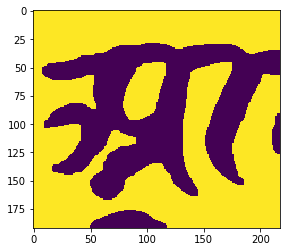

In [18]:
show_image(final)

In [9]:
def load_data():
    """ Function to load data. """
    
    chars = os.listdir('chars')
    non_chars = os.listdir('non_chars')
    
    labels = []
    
    # Load char images
    char_images = []
    for i in tqdm(range(len(chars)), desc='Preprocessing chars...'):
        fname = chars[i]
        
        _, final = transform_image('chars/' + fname)
        _, final_up = transform_image('chars/' + fname, 'up')
        _, final_down = transform_image('chars/' + fname, 'down')
        
        final = np.reshape(final, (final.shape[0], final.shape[1], 1))
        final_up = np.reshape(final_up, (final_up.shape[0], final_up.shape[1], 1))
        final_down = np.reshape(final_down, (final_down.shape[0], final_down.shape[1], 1))
        
        char_images.append(final)
        char_images.append(final_up)
        char_images.append(final_down)
        
        for i in range(3):
            labels.append(1)
        
    # Load non-char images
    non_char_images = []
    for i in tqdm(range(len(non_chars)), desc='Preprocessing non-chars...'):
        fname = non_chars[i]

        _, final = transform_image('non_chars/' + fname)
        _, final_up = transform_image('non_chars/' + fname, 'up')
        _, final_down = transform_image('non_chars/' + fname, 'down')
        
        final = np.reshape(final, (final.shape[0], final.shape[1], 1))
        final_up = np.reshape(final_up, (final_up.shape[0], final_up.shape[1], 1))
        final_down = np.reshape(final_down, (final_down.shape[0], final_down.shape[1], 1))
        
        non_char_images.append(final)
        non_char_images.append(final_up)
        non_char_images.append(final_down)
        
        for i in range(3):
            labels.append(0)
        
    # Random Shuffling
    X = np.array(char_images + non_char_images)
    y = np.array(labels)
    
    s = np.arange(X.shape[0])
    np.random.shuffle(s)
    
    X = X[s]
    y = y[s]
    
    return X, y

In [10]:
X, y = load_data()

Preprocessing non-chars...: 100%|██████████| 50/50 [00:40<00:00,  1.26it/s]


In [15]:
y = to_categorical(y)
X.shape, y.shape

((303, 118, 130, 1), (303, 2))

**Model Building**

Build a ConvNet to make predictions on the data. 

In [16]:
POOL_SIZE = (2, 2) # These are usually the values
KERNEL_SIZE = (3, 3)

# Create model
model = Sequential()

model.add(Conv2D(64, input_shape=(118, 130, 1), 
                 activation='relu', kernel_size=KERNEL_SIZE))
model.add(Conv2D(32, activation='relu', kernel_size=KERNEL_SIZE))
model.add(MaxPooling2D(pool_size=POOL_SIZE))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [17]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
model.fit(X, y, batch_size=20, epochs=1, validation_split=0.2, shuffle=True)

Instructions for updating:
Use tf.cast instead.
Train on 242 samples, validate on 61 samples
Epoch 1/1
242/242 [==============================] - 20s 83ms/step - loss: 8.0675 - acc: 0.4835 - val_loss: 7.9269 - val_acc: 0.5082
